## Importing Libraries

In [1]:
from sklearn.metrics import accuracy_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# Importing and Visualizing Data

In [2]:
data=pd.read_csv('dataset3.csv',index_col= 'Date')
data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
4/29/2022,20271.40039,21176.58008,20040.07031,21089.39063,21089.39063,2.727108e+09
4/28/2022,20118.78906,20286.83008,19956.66992,20276.16992,20276.16992,2.255667e+09
4/27/2022,19723.46094,20053.10938,19665.49023,19946.35938,19946.35938,2.361022e+09
4/26/2022,19989.03906,20258.64063,19858.35938,19934.71094,19934.71094,2.565707e+09
4/25/2022,20284.59961,20284.59961,19784.27930,19869.33984,19869.33984,2.912292e+09


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1.724000e+03
mean,25731.011982,25875.566292,25542.193274,25712.942877,25712.942877,1.944150e+09
std,3009.022576,3010.987173,2995.949780,3003.715626,3003.715626,6.999819e+08
min,18278.800780,18482.330080,18235.480470,18319.580080,18319.580080,0.000000e+00
25%,23546.802738,23642.283203,23331.155273,23519.140137,23519.140137,1.496752e+09
50%,25907.589845,26048.225590,25714.370115,25878.315430,25878.315430,1.795762e+09
75%,28103.824707,28267.004885,27925.402345,28122.469725,28122.469725,2.201660e+09
max,33335.480470,33484.078130,32897.039060,33154.121090,33154.121090,6.012760e+09


In [4]:
data.info

<bound method DataFrame.info of                   Open         High          Low        Close    Adj Close  \
Date                                                                         
4/29/2022  20271.40039  21176.58008  20040.07031  21089.39063  21089.39063   
4/28/2022  20118.78906  20286.83008  19956.66992  20276.16992  20276.16992   
4/27/2022  19723.46094  20053.10938  19665.49023  19946.35938  19946.35938   
4/26/2022  19989.03906  20258.64063  19858.35938  19934.71094  19934.71094   
4/25/2022  20284.59961  20284.59961  19784.27930  19869.33984  19869.33984   
...                ...          ...          ...          ...          ...   
5/8/2015   27557.51953  27652.61914  27367.10938  27577.33984  27577.33984   
5/7/2015   27567.61914  27604.49023  27207.27930  27289.97070  27289.97070   
5/6/2015   27698.09961  28054.67969  27570.41016  27640.91016  27640.91016   
5/5/2015   28295.72070  28316.63086  27598.16992  27755.53906  27755.53906   
5/4/2015   28231.25977  28343.74

In [5]:
data[data.isna()==True].sum().sum()

0.0

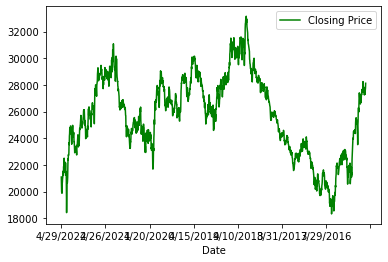

In [6]:

data['Adj Close'].plot(label='Closing Price', color='g');
plt.legend();


# Feature Engineering and data Split

In [7]:
# Features construction
data["Open-Close"] = (data.Open - data.Close)/data.Open
data["High-Low"] = (data.High - data.Low)/data.Low
data["percent_change"] = data["Adj Close"].pct_change()
data["std_20"] = data["percent_change"].rolling(20).std()
data["ret_20"] = data["percent_change"].rolling(20).mean()
data['SMA'] = data['Adj Close'].rolling(window=20).mean().shift(1)
data['dist_from_mean'] = data['Adj Close'].shift(1) - data['SMA']
data['ON_returns'] = data['Close'] - data['Open'].shift(-1)
data['Band_1'] = data['SMA'] - data['std_20']
data['Band_2'] = data['SMA'] + data['std_20']
data['ON_returns'] = data['ON_returns'].shift(1)
data['signal'] = np.where(data['ON_returns']<0, 1, 0)
data['dist_from_mean'] = data['Adj Close'].shift(1) - data['SMA']
comb_features = pd.concat([data,data], axis=1)
comb_features = comb_features.dropna() #dropping NaN values
comb_features = pd.get_dummies(comb_features, columns=['signal']) #for categorical variables
comb_features = comb_features.drop('ON_returns', axis=1) #dropping original categorical column
comb_features = comb_features.drop('Close', axis=1)
data.dropna(inplace=True)

# X is the input variable

x = data[['percent_change', "std_20",'signal', "ret_20",'Band_1','Band_2']]

# Y is the target or output variable
y = np.where(data["Adj Close"].shift(-1) > data["Adj Close"],1,0)


In [8]:
y

array([0, 0, 1, ..., 1, 1, 0])

In [9]:
# Total dataset length

dataset_length = data.shape[0]


# Trainig dataset length
split = int(dataset_length * 0.20)

In [10]:
# Splitiing the X and y into train and test datasets

x_train, x_test = x[split:], x[:split]
y_train, y_test = y[split:], y[:split]

# Print the size of the train and test dataset

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1364, 6) (340, 6)
(1364,) (340,)


In [11]:
x_train.tail()

,percent_change,std_20,signal,ret_20,Band_1,Band_2
Date,,,,,,
5/8/2015,-0.005082,0.009800,0,0.000521,27596.446744,27596.466344
5/7/2015,-0.010420,0.010090,0,0.000103,27609.499481,27609.519661
5/6/2015,0.012860,0.010220,1,0.000211,27610.989878,27611.010318
5/5/2015,0.004147,0.010226,1,0.000227,27615.440849,27615.461300
5/4/2015,0.013269,0.010478,1,0.001235,27620.344015,27620.364970


# Fitting Random Forest and predicting the next 5 days

0.6705882352941176

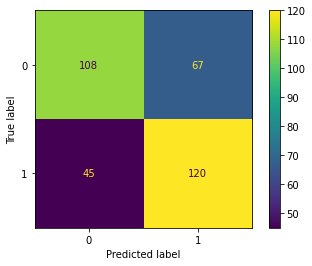

In [14]:

# Step 4: Fit a Random Forest model, " compared to "Decision Tree model, accuracy go up by 5%
clf = RandomForestClassifier(n_estimators=100,min_samples_split=2,random_state=1, min_samples_leaf=9,max_depth=5,bootstrap='True')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
plot_confusion_matrix(clf, x_test, y_test);
accuracy_score(y_test, y_pred)


In [15]:
accuracy ={}
for i in range(1,3):
    clf = RandomForestClassifier(n_estimators=i, random_state=1)
    clf.fit(x_train, y_train)
    y_pred_ev = clf.predict(x_test)
    accuracy[i] = accuracy_score(y_test, y_pred_ev)

In [16]:
max(accuracy.values())

0.638235294117647

In [ ]:
grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=clf, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

In [17]:
importances = pd.DataFrame({'feature':x_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
0,percent_change,0.242
1,std_20,0.195
3,ret_20,0.156
5,Band_2,0.154
4,Band_1,0.141
2,signal,0.110


In [18]:
clf.feature_importances_

array([0.24217145, 0.19528206, 0.11034305, 0.15645672, 0.14140104,
       0.15434567])

In [ ]:
predictions = pd.DataFrame({"Predictions": y_pred}, index=pd.date_range(start=data.index[-1], periods=len(predict), freq="D"))
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

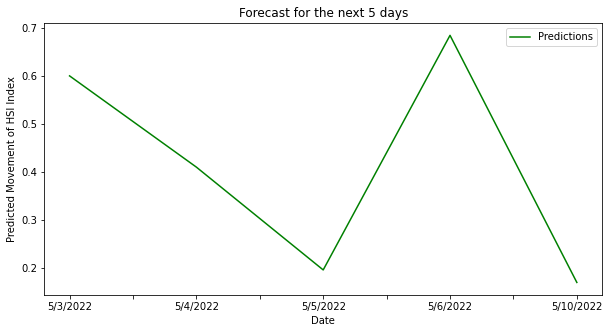

In [156]:
fivedays_df_pred = pd.read_csv("five-days-predictions.csv")
fivedays_df_pred.set_index("Date", inplace=True)
buy_price = min(fivedays_df_pred["Predictions"])
sell_price = max(fivedays_df_pred["Predictions"])
fivedays_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the next 5 days", color="Green")
plt.xlabel("Date")
plt.ylabel("Predicted Movement of HSI Index")
plt.legend()
plt.show()

# Fitting AdaBoost Model

0.6647058823529411

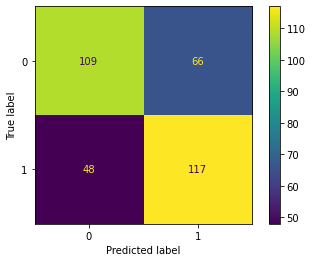

In [20]:

# Step 5: Fit a AdaBoost model, " compared to "Decision Tree model, accuracy go up by 10%
clf = AdaBoostClassifier(n_estimators=1,learning_rate=1)
model=clf.fit(x_train, y_train)
y_pred = model.predict(x_test)
plot_confusion_matrix(clf, x_test, y_test)
accuracy_score(y_test, y_pred)

In [151]:
from sklearn.model_selection import GridSearchCV
#Creating a grid of hyperparameters
grid_params = {'n_estimators': [100,200,300]}
#Building a 3 fold CV GridSearchCV object
grid_object = GridSearchCV(estimator = clf, param_grid = grid_params, scoring = 'accuracy', cv = 3, n_jobs = -1)
#Fitting the grid to the training 
grid_object.fit(x_train, y_train)
#Extracting the best parametersgrid_object.bestparams ...

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(learning_rate=1, n_estimators=1),
             n_jobs=-1, param_grid={'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [152]:
importances = pd.DataFrame({'feature':x_train.columns,'importance':np.round(clf.feature_importances_,8)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
2,signal,1.0
0,percent_change,0.0
1,std_20,0.0
3,ret_20,0.0
4,Band_1,0.0
5,Band_2,0.0


In [75]:
model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[0.50003885 0.41003651 0.99596923 0.28442127 0.36989228 0.43668296
 0.50739902 0.65809297 0.68115834 0.57394736 0.89388543 0.57662569
 0.4687946  0.66103588 0.50478111 0.61417625 0.5959216  0.4949243
 0.59955384 0.96396923 0.68734228 0.88399812 0.6741423  0.60047982
 0.66768924 0.99596923 0.31985786 0.37166382 0.3396906  0.51872851
 0.66879699 0.21777998 0.15794501 0.44489973 0.27035866 0.68766147
 0.10684884 0.07037001 0.44345636 0.99196923 0.50101722 0.44349569
 0.04711098 0.47807071 0.4231539  0.09672261 0.48438354 0.92916392
 0.68999347 0.03653529 0.57617115 0.18790654 0.41911037 0.0893112
 0.46066555 0.40724021 0.65625788 0.46366551 0.96396335 0.54625518
 0.43026087 0.97045561 0.49130474 0.89288847 0.17072624 0.94249855
 0.33649118 0.78225689 0.34971486 0.53313632 0.88170887 0.4818047
 0.57063707 0.57841028 0.52002609 0.42980167 0.10909672 0.5169722
 0.39688984 0.08944266 0.24289795 0.98968463 0.52030033 0.47964654
 0.43068258 0.04846592 0.91659657 0.21339335 0.04853447 0.5796769
